Importing neccesary libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


loading data

In [2]:
geo_loc = pd.read_csv("GEO_LOCATION.csv")
order_item = pd.read_csv("ORDER_ITEMS.csv")
order_payments = pd.read_csv("ORDER_PAYMENTS.csv")
order_review = pd.read_csv("ORDER_REVIEW_RATINGS.csv")
orders = pd.read_csv("ORDERS.csv")
products = pd.read_csv("PRODUCTS.csv")
sellers = pd.read_csv("SELLERS.csv")
customer = pd.read_csv("CUSTOMERS.csv")

data prep

In [3]:
for col in orders.columns[3:]:
    orders[col] = pd.to_datetime(orders[col])
order_item.shipping_limit_date = pd.to_datetime(order_item.shipping_limit_date)
order_review.review_creation_date = pd.to_datetime(order_review.review_creation_date)
order_review.review_answer_timestamp = pd.to_datetime(order_review.review_answer_timestamp)

business objectives

In [5]:
total_revenue = pd.merge(orders,order_payments,on="order_id",how="inner").payment_value.sum()
total_quantity = len(orders)
total_products = len(products)
total_categories = len(products.product_category_name.unique())
total_seller = len(sellers.seller_id.unique())
total_cities = customer.customer_city.nunique()
total_payment_methods = order_payments.payment_type.nunique()

In [6]:
#1a
print("Metrics\n")
print(f"Total Revenue         :  {total_revenue}")
print(f"Total Quantity        :  {total_quantity}")
print(f"Total Products        :  {total_products}")
print(f"Total Categories      :  {total_categories}")
print(f"Total Sellers         :  {total_seller}")
print(f"Total Cities          :  {total_cities}")
print(f"Total States          :  {customer.customer_state.nunique()}")
print(f"Total Payment Methods :  {total_payment_methods}")

Metrics

Total Revenue         :  16008872.12
Total Quantity        :  99441
Total Products        :  32951
Total Categories      :  72
Total Sellers         :  3095
Total Cities          :  4119
Total States          :  20
Total Payment Methods :  5


In [7]:
#merged dataset
order_item_t = order_item.drop(columns=["order_item_id"])
order_item_t.drop_duplicates(inplace=True)
merged_df = customer.merge(orders)\
.merge(order_item_t)\
.merge(order_review)\
.merge(sellers)\
.merge(products)\
.merge(geo_loc,right_on="geolocation_zip_code_prefix",left_on="customer_zip_code_prefix")


temp = merged_df.groupby("customer_id").agg({"order_purchase_timestamp":"count"}).sort_values("order_purchase_timestamp",ascending=False)
temp["repeat_customer"]=np.where(temp.order_purchase_timestamp == 1,0,1)
temp.drop(columns=["order_purchase_timestamp"],inplace=True)
temp.reset_index(inplace=True)
merged = merged_df.merge(temp,on="customer_id")

In [7]:
'''merged.sort_values("order_purchase_timestamp",inplace=True)
list1 = []
first_order = []
for i in merged.customer_id:
    if i in list1:
        first_order.append(0)
    else:
        first_order.append(1)
        list1.append(i)
merged["first_order"] = first_order'''
#this code take 10 mins to run
       

'merged.sort_values("order_purchase_timestamp",inplace=True)\nlist1 = []\nfirst_order = []\nfor i in merged.customer_id:\n    if i in list1:\n        first_order.append(0)\n    else:\n        first_order.append(1)\n        list1.append(i)\nmerged["first_order"] = first_order'

In [8]:
#the above code takes too much time as the data is huge so i saved the result as a csv
# use this code 
#merged.to_csv("merged.csv")
merged = pd.read_csv("merged.csv")
merged = merged.iloc[:,1:]
for i in range(7,12):
    merged.iloc[:,i] = pd.to_datetime(merged.iloc[:,i])
merged.shipping_limit_date = pd.to_datetime(merged.shipping_limit_date)
merged.review_creation_date = pd.to_datetime(merged.review_creation_date)
merged.review_answer_timestamp = pd.to_datetime(merged.review_answer_timestamp)
merged["month"]=merged.order_purchase_timestamp.dt.year.astype(str) + "/" + merged.order_purchase_timestamp.dt.month.astype(str).apply(lambda x :"0"+x if len(x)<2 else x)

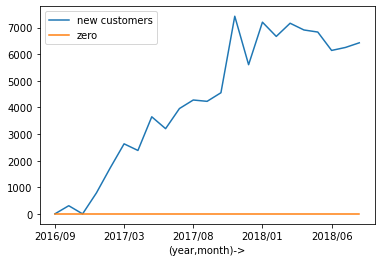

In [9]:
#1b
df_b = merged[merged.first_order==1].groupby("month")["first_order"].count()[:-1]
df_b.plot()
line = []
for i in range(len(df_b)):
    line.append(0)
line = pd.DataFrame(line)
plt.plot(line)
plt.legend(["new customers","zero"])
plt.xlabel("(year,month)->")
plt.show()

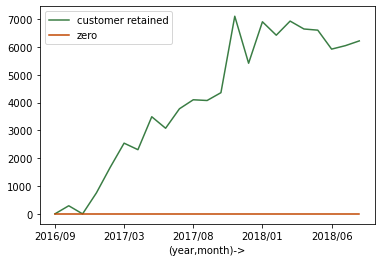

In [10]:
#1c
df_c = merged[(merged.first_order == 1) & (merged.repeat_customer == 1)].groupby("month")["customer_id"].count()[:-1]
df_c.plot(color="#3A7D44")
line = pd.DataFrame(line)
plt.plot(line,color="#C14600")
plt.legend(["customer retained","zero"])
plt.xlabel("(year,month)->")
plt.show()

<AxesSubplot:xlabel='order_purchase_timestamp,order_purchase_timestamp'>

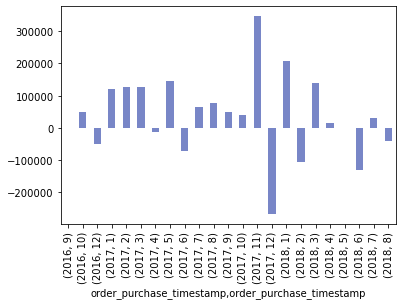

In [11]:
#1d
customer_rev = customer.merge(orders).merge(order_item)
mom_change = customer_rev.groupby([customer_rev["order_purchase_timestamp"].dt.year,customer_rev["order_purchase_timestamp"].dt.month]).agg({"price":"sum"})
mom_change["mom_revenue"] = mom_change['price'].diff()

mom_change["is_profit"] = np.where(mom_change.mom_revenue>0,1,0)

mom_change.mom_revenue[:-1].plot(kind="bar",color="#7886C7")

In [15]:
#1 e

cat_df = merged.groupby("product_category_name").agg({"price":"sum", "product_photos_qty":"sum"}).reset_index()
cat_df.rename(columns = {"product_category_name": "categories" ,"price" : "revenue","product_photos_qty" : "quantity"}, inplace = True)
cat_df.sort_values(["revenue","quantity"],ascending=False,ignore_index=True)

,categories,revenue,quantity
0,Health_Beauty,1213961.78,16711.0
1,Watches_Gifts,1182675.61,14477.0
2,Bed_Bath_Table,974330.01,15425.0
3,Sports_Leisure,933606.31,17659.0
4,Computers_Accessories,808312.48,12344.0
...,...,...,...
66,Flowers,962.94,33.0
67,Home_Comfort_2,682.87,25.0
68,Cds_Dvds_Musicals,640.00,24.0
69,Fashion_Childrens_Clothes,569.85,21.0


In [13]:
location = merged.groupby("customer_city").agg({"price":"sum", "product_photos_qty":"sum"}).reset_index()
location.columns = ["location","revenue","quantity"]
location.sort_values(["revenue","quantity"],ascending=False,ignore_index=True).head()

,location,revenue,quantity
0,Akkarampalle,1797780.54,35220.0
1,Badepalle,923200.57,15254.0
2,Anantapur,338479.66,6262.0
3,Eddumailaram,265776.71,4512.0
4,Anakapalle,196087.22,3522.0


In [14]:
month_df = merged.groupby("month").agg({"price":"sum","customer_id":"count"})
month_df.columns = ["revenue","quantity"]
month_df.sort_values("revenue",ascending=False).head()


,revenue,quantity
month,,
2017/11,939657.77,7819
2018/04,938809.88,7221
2018/05,926309.52,7108
2018/03,921074.82,7437
2018/01,896375.42,7549


In [16]:
week_df = merged.groupby(merged.order_purchase_timestamp.dt.isocalendar().week).agg({"price":"sum","customer_id":"count"})
week_df.columns = ["revenue","quantity"]
week_df.sort_values("revenue",ascending=False).head()

,revenue,quantity
week,,
32,380870.90,3014
47,378772.07,3143
31,376869.78,3141
19,374118.12,2861
20,357762.32,2904


In [17]:
hour_df = merged.groupby(merged.order_purchase_timestamp.dt.hour).agg({"price":"sum","customer_id":"count"}).reset_index()
hour_df.columns = ["Hour","revenue","quantity"]
hour_df.sort_values("revenue",ascending=False,ignore_index=True).head()

,Hour,revenue,quantity
0,14,879680.47,6820
1,16,868814.19,6898
2,15,832011.69,6677
3,11,820378.55,6760
4,13,812452.57,6734


1pm to 4pm is the golden hours of revenue 

In [18]:
day_df = merged.groupby(merged.order_purchase_timestamp.dt.day).agg({"price":"sum","customer_id":"count"}).reset_index()
day_df.columns = ["day","revenue","quantity"]
day_df.sort_values("revenue",ascending=False,ignore_index=True).head()

,day,revenue,quantity
0,24,484532.39,4042
1,4,471537.18,3605
2,16,468049.62,3725
3,18,463411.32,3543
4,6,455500.94,3557


In [19]:
payment_df = order_payments.groupby("payment_type").agg({"payment_value":"sum","order_id":"count"})
payment_df.columns = ["revenue","quantity"]
payment_df.sort_values("revenue",ascending=False)

,revenue,quantity
payment_type,,
credit_card,12542084.19,76795
UPI,2869361.27,19784
voucher,379436.87,5775
debit_card,217989.79,1529
not_defined,0.00,3


In [20]:
#1f
#Popular Product by Month
md = merged.pivot_table(index=["product_id",merged["order_purchase_timestamp"].dt.month_name()],values="order_id",aggfunc="count").reset_index()
product_month = md.groupby("order_purchase_timestamp")["order_id"].max().reset_index()
list1 = []
for i in range(len(product_month)):
    list1.append(md[(md.order_purchase_timestamp == product_month.order_purchase_timestamp[i])&(md.order_id == product_month.order_id[i])].product_id.values[0])
product_month["popular_product"]=list1
product_month.columns = ["Months","times_ordered","popular_product"]
product_month.set_index("Months").loc[["January","February","March","April","May","June","July","August","September","October","November","December"]]

,times_ordered,popular_product
Months,,
January,107,aca2eb7d00ea1a7b8ebd4e68314663af
February,64,3dd2a17168ec895c781a9191c1e95ad7
March,56,aca2eb7d00ea1a7b8ebd4e68314663af
April,80,53b36df67ebb7c41585e8d54d6772e08
May,106,53b36df67ebb7c41585e8d54d6772e08
June,68,99a4788cb24856965c36a24e339b6058
July,70,99a4788cb24856965c36a24e339b6058
August,53,73326828aa5efe1ba096223de496f596
September,33,422879e10f46682990de24d770e7f83d


In [21]:
#Popular Product by seller
md = merged.pivot_table(index=["product_id","seller_id"],values="order_id",aggfunc="count").reset_index()
product_seller = md.groupby("seller_id")["order_id"].max().reset_index()
list1 = []
for i in range(len(product_seller)):
    list1.append(md[(md.seller_id == product_seller.seller_id[i])&(md.order_id == product_seller.order_id[i])].product_id.values[0])
product_seller["popular_product"]=list1
product_seller.columns = ["Sellers","times_ordered","popular_product"]
product_seller.sort_values("times_ordered",ascending=False,ignore_index=True)

,Sellers,times_ordered,popular_product
0,4a3ca9315b744ce9f8e9374361493884,463,99a4788cb24856965c36a24e339b6058
1,955fee9216a65b617aa5c0531780ce60,429,aca2eb7d00ea1a7b8ebd4e68314663af
2,1f50f920176fa81dab994f9023523100,353,422879e10f46682990de24d770e7f83d
3,a1043bafd471dff536d0c462352beb48,322,d1c427060a0f73f6b889a5c7c61f2ac4
4,cc419e0650a3c5ba77189a1882b7556a,278,154e7e31ebfa092203795c972e5804a6
...,...,...,...
3090,bb3dca718920a4d7ec3cc9ffb025108b,1,7cbe64a84bc3fba260c50858e7d402d6
3091,570d4583587a5fe2d47c7be89b91ad27,1,9d09afe70e3f77b5999d6199ab66e98f
3092,baf15155e37ef5492731459bdc05be8a,1,07145f317bd27c212bbc49377b3940dd
3093,baeda7047354773262ba2405f97038ba,1,cea2c8d87c3a6672684f57374dfc5703


In [22]:
#Popular Product by state
md = merged.pivot_table(index=["product_id","customer_state"],values="order_id",aggfunc="count").reset_index()
product_state = md.groupby("customer_state")["order_id"].max().reset_index()
list1 = []
for i in range(len(product_state)):
    list1.append(md[(md.customer_state == product_state.customer_state[i])&(md.order_id == product_state.order_id[i])].product_id.values[0])
product_state["popular_product"]=list1
product_state.columns = ["State","times_ordered","popular_product"]
product_state.sort_values("times_ordered",ascending=False,ignore_index=True)

,State,times_ordered,popular_product
0,Andhra Pradesh,283,99a4788cb24856965c36a24e339b6058
1,Gujarat,39,aca2eb7d00ea1a7b8ebd4e68314663af
2,Chhattisgarh,29,422879e10f46682990de24d770e7f83d
3,Karnataka,21,154e7e31ebfa092203795c972e5804a6
4,Delhi,18,53759a2ecddad2bb87a079a1f1519f73
5,Madhya Pradesh,17,99a4788cb24856965c36a24e339b6058
6,Tamil Nadu,13,99a4788cb24856965c36a24e339b6058
7,Haryana,13,2b4609f8948be18874494203496bc318
8,Maharashtra,13,99a4788cb24856965c36a24e339b6058
9,Kerala,10,aca2eb7d00ea1a7b8ebd4e68314663af


In [23]:
#Popular Product by category
md = merged.pivot_table(index=["product_id","product_category_name"],values="order_id",aggfunc="count").reset_index()
product_cat = md.groupby("product_category_name")["order_id"].max().reset_index()
list1 = []
for i in range(len(product_cat)):
    list1.append(md[(md.product_category_name == product_cat.product_category_name[i])&(md.order_id == product_cat.order_id[i])].product_id.values[0])
product_cat["popular_product"]=list1
product_cat.columns = ["State","times_ordered","popular_product"]
product_cat.sort_values("times_ordered",ascending=False,ignore_index=True)

,State,times_ordered,popular_product
0,Bed_Bath_Table,469,99a4788cb24856965c36a24e339b6058
1,Furniture_Decor,429,aca2eb7d00ea1a7b8ebd4e68314663af
2,Garden_Tools,353,422879e10f46682990de24d770e7f83d
3,Computers_Accessories,322,d1c427060a0f73f6b889a5c7c61f2ac4
4,Watches_Gifts,305,53b36df67ebb7c41585e8d54d6772e08
...,...,...,...
66,Music,4,4befae07dba4384f6d8237ad1e7f8294
67,Fashion_Childrens_Clothes,3,57bdf3098169cccdb62221bd3e089cbd
68,Fashion_Sport,3,a38e6346616a8f362c328b9537b1ca4d
69,La_Cuisine,2,2365562e74dd46f5e99cdc696c504cea


In [24]:
#1g
#Popular Product Category by State

md = merged.pivot_table(index=["product_category_name","customer_state"],values="order_id",aggfunc="count").reset_index()
product_cat_state = md.groupby("customer_state")["order_id"].max().reset_index()
list1 = []
for i in range(len(product_cat_state)):
    list1.append(md[(md.customer_state == product_cat_state.customer_state[i])&(md.order_id == product_cat_state.order_id[i])].product_category_name.values[0])
product_cat_state["popular_product"]=list1
product_cat_state.columns = ["State","times_ordered","popular_cat"]
product_cat_state.sort_values("times_ordered",ascending=False,ignore_index=True)


,State,times_ordered,popular_cat
0,Andhra Pradesh,6527,Bed_Bath_Table
1,Gujarat,707,Bed_Bath_Table
2,Chhattisgarh,639,Bed_Bath_Table
3,Karnataka,370,Bed_Bath_Table
4,Delhi,316,Health_Beauty
5,Madhya Pradesh,304,Bed_Bath_Table
6,Haryana,255,Bed_Bath_Table
7,Tamil Nadu,204,Bed_Bath_Table
8,Maharashtra,202,Bed_Bath_Table
9,Jammu & Kashmir,153,Bed_Bath_Table


In [25]:

#Popular Product Category by month

md = merged.pivot_table(index=["product_category_name",merged["order_purchase_timestamp"].dt.month_name()],values="order_id",aggfunc="count").reset_index()
product_cat_month = md.groupby("order_purchase_timestamp")["order_id"].max().reset_index()
list1 = []
for i in range(len(product_cat_month)):
    list1.append(md[(md.order_purchase_timestamp == product_cat_month.order_purchase_timestamp[i])&(md.order_id == product_cat_month.order_id[i])].product_category_name.values[0])
product_cat_month["popular_product"]=list1
product_cat_month.columns = ["Months","times_ordered","popular_cat"]
product_cat_month.set_index("Months").loc[["January","February","March","April","May","June","July","August","September","October","November","December"]]


,times_ordered,popular_cat
Months,,
January,826,Bed_Bath_Table
February,957,Computers_Accessories
March,999,Bed_Bath_Table
April,927,Bed_Bath_Table
May,1010,Bed_Bath_Table
June,1079,Bed_Bath_Table
July,1123,Bed_Bath_Table
August,1156,Health_Beauty
September,493,Bed_Bath_Table


In [26]:
#1h
merged.groupby(["product_id","product_category_name"]).agg({"price":"max"}).sort_values("price",ascending=False).head(10)


,,price
product_id,product_category_name,
489ae2aa008f021502940f251d4cce7f,Housewares,6735.00
69c590f7ffc7bf8db97190b6cb6ed62e,Computers,6729.00
1bdf5e6731585cf01aa8169c7028d6ad,Art,6499.00
a6492cc69376c469ab6f61d8f44de961,Small_Appliances,4799.00
c3ed642d592594bb648ff4a04cee2747,Small_Appliances,4690.00
259037a6a41845e455183f89c5035f18,Computers,4590.00
a1beef8f3992dbd4cd8726796aa69c53,Musical_Instruments,4399.87
6cdf8fc1d741c76586d8b6b15e9eef30,Consoles_Games,4099.99
dd113cb02b2af9c8e5787e8f1f0722f6,Sports_Leisure,4059.00


In [27]:
#2
cust_seg = merged.merge(order_payments).groupby("customer_id").agg({"payment_value":"sum"})
cust_seg["Segment"] = np.where(cust_seg.payment_value>2000,"Gold",np.where(cust_seg.payment_value>200,"Silver","Bronze"))
cust_seg.columns = ["Total_revenue","Segment"]
cust_seg.reset_index(inplace=True)
customer = customer.merge(cust_seg)
customer.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,Total_revenue,Segment
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,Adilabad,Andhra Pradesh,146.87,Bronze
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,Adoni,Andhra Pradesh,335.48,Silver
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,Akkarampalle,Andhra Pradesh,157.73,Bronze
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,Akkayapalle,Andhra Pradesh,173.30,Bronze
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,Alwal,Andhra Pradesh,252.25,Silver


In [28]:
seller_seg = merged.merge(order_payments).groupby("seller_id").agg({"payment_value":"sum"})
seller_seg["Segment"] = np.where(seller_seg.payment_value>20000,"Gold",np.where(seller_seg.payment_value>4000,"Silver","Bronze"))
seller_seg.columns = ["Total_revenue","seller_tier"]
seller_seg.reset_index(inplace=True)
sellers = sellers.merge(seller_seg)
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state,Total_revenue,seller_tier
0,3442f8959a84dea7ee197c632cb2df15,13023,Alwal,Andhra Pradesh,392.18,Bronze
1,d1b65fc7debc3361ea86b5f14c68d2e2,13023,Alwal,Andhra Pradesh,13627.82,Silver
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,Badepalle,Andhra Pradesh,174.21,Bronze
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,Akkarampalle,Andhra Pradesh,95.65,Bronze
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,Koratla,Andhra Pradesh,199.92,Bronze


In [29]:
#3
cross_df = merged.groupby("customer_id").agg({"product_id":"nunique"})
cross_cust = list(cross_df[cross_df.product_id>1].reset_index().customer_id)
cc = merged[merged.customer_id.isin(cross_cust)].pivot_table(index=["customer_id","product_id"],values="order_id",aggfunc="count").reset_index().sort_values("customer_id")
list1 = []
list2 = []
val = ""
for i in range(len(cc)):
    if cc.customer_id[i] != val:
        val=cc.customer_id[i]
        list1.append(list2)
        list2 = [cc.product_id[i]]
    else:
        list2.append(cc.product_id[i])

len_list = []
for i in range(len(list1)):
    len_list.append(len(list1[i]))

cross_prod = pd.DataFrame([list1,len_list]).T.sort_values(1,ascending=False,ignore_index=True).head(10)
cross_prod.columns = ["products","ordered_in_batch"]
cross_prod

,products,ordered_in_batch
0,"[0cf2faf9749f53924cea652a09d8e327, 0de59eddc63...",8
1,"[2196812e80b905c7071389c10ad035d3, 6d0a373c460...",7
2,"[0e35a413d832e63c5d46101b7c88de0f, 154696c4f8e...",7
3,"[26facbccf840188b92bcc8cb89fe1f64, 507914b4af2...",7
4,"[238314b88e4b8ffa496db6b1a201d897, 28447390cfd...",6
5,"[0f6e214a2c5baab8c1ccb053a0829f13, 274d4e727dd...",6
6,"[15b5d9fcf84c060e00b0883def7d10e6, 22c7191da97...",6
7,"[0e92dcf7b03df1de4e9349af065f8e63, 1f1354b0aa9...",6
8,"[17d8b8e9c21ec0fc5b33724e32fe422e, 399f54c0666...",6
9,"[27761f21b03a32be1aad6ebaebddd747, 368645a47a1...",6


In [30]:
#4

orders.merge(order_payments).payment_type.value_counts()

credit_card    76795
UPI            19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

credit card is the most used type of payment method used by customers

In [31]:
#5 a
merged.groupby(['product_category_name']).agg({'review_score':"sum"}).sort_values("review_score",ascending=False).head(10)

,review_score
product_category_name,
Bed_Bath_Table,39984
Health_Beauty,37646
Sports_Leisure,32708
Computers_Accessories,27616
Furniture_Decor,27071
Housewares,24782
Watches_Gifts,23310
Telephony,16987
Toys,16539


In [32]:
# 5 a
merged.groupby(['product_category_name']).agg({'review_score':"sum"}).sort_values("review_score").head(10)

,review_score
product_category_name,
Security_And_Services,5
Fashion_Childrens_Clothes,36
La_Cuisine,52
Cds_Dvds_Musicals,56
Home_Comfort_2,89
Arts_And_Craftmanship,99
Diapers_And_Hygiene,101
Fashion_Sport,110
Flowers,124


In [33]:
#5 b
merged.groupby(['product_id']).agg({'review_score':"sum"}).sort_values("review_score",ascending=False).head(10)

,review_score
product_id,
99a4788cb24856965c36a24e339b6058,1812
aca2eb7d00ea1a7b8ebd4e68314663af,1754
422879e10f46682990de24d770e7f83d,1453
d1c427060a0f73f6b889a5c7c61f2ac4,1357
389d119b48cf3043d311335e499d9c6b,1292
53b36df67ebb7c41585e8d54d6772e08,1285
368c6c730842d78016ad823897a372db,1200
154e7e31ebfa092203795c972e5804a6,1198
53759a2ecddad2bb87a079a1f1519f73,1148


In [34]:
#5 b

merged.groupby(['product_id']).agg({'review_score':"sum"}).sort_values("review_score").head(10)

,review_score
product_id,
7f6b034a2bb30ba8e1da93017a86bd58,1
8722afd14143e0192b2abbcee6fe2873,1
cd23ec4a774a11839255737299a05f4d,1
873c256958122a0b04f65c23f8bc2329,1
2404d9b539ebddc4401a24da18215fc4,1
cd064963187616d33281791cd6538171,1
24016cd8f7a556eaaf043552e23df9f4,1
87590844d536e6b92ecf707a50b1c2c5,1
878699846fa5ea02a5b41e59f7c4439d,1


In [35]:
#5 c
city_rate = merged.groupby(['customer_city']).agg({"review_score":"mean"}).round(2)
seller_rate = merged.groupby(["seller_id"]).agg({"review_score":"mean"}).round(2)
prod_rate = merged.groupby(["product_id"]).agg({"review_score":"mean"}).round(2)
cat_rate = merged.groupby(["product_category_name"]).agg({"review_score":"mean"}).round(2)
month_rate = merged.groupby([merged.order_purchase_timestamp.dt.month]).agg({"review_score":"mean"}).round(2)

In [36]:
city_rate

,review_score
customer_city,
Aadityana,3.83
Aambaliyasan,3.50
Aantaliya,3.99
Aarambhada,3.70
Abiramam,5.00
...,...
Zamin Uthukuli,4.00
Ziauddin Pur,4.00
Zira,4.50


In [37]:
seller_rate

,review_score
seller_id,
0015a82c2db000af6aaaf3ae2ecb0532,3.67
001cca7ae9ae17fb1caed9dfb1094831,3.94
001e6ad469a905060d959994f1b41e4f,1.00
002100f778ceb8431b7a1020ff7ab48f,3.98
003554e2dce176b5555353e4f3555ac8,5.00
...,...
ffcfefa19b08742c5d315f2791395ee5,1.00
ffdd9f82b9a447f6f8d4b91554cc7dd3,4.33
ffeee66ac5d5a62fe688b9d26f83f534,4.21


In [38]:
prod_rate

,review_score
product_id,
00066f42aeeb9f3007548bb9d3f33c38,5.0
00088930e925c41fd95ebfe695fd2655,4.0
0009406fd7479715e4bef61dd91f2462,1.0
000b8f95fcb9e0096488278317764d19,5.0
000d9be29b5207b54e86aa1b1ac54872,5.0
...,...
fff6177642830a9a94a0f2cba5e476d1,4.5
fff81cc3158d2725c0655ab9ba0f712c,4.0
fff9553ac224cec9d15d49f5a263411f,5.0


In [39]:
cat_rate

,review_score
product_category_name,
Agro_Industry_And_Commerce,4.03
Air_Conditioning,3.98
Art,4.00
Arts_And_Craftmanship,4.12
Audio,3.81
...,...
Stationery,4.22
Tablets_Printing_Image,4.08
Telephony,3.97


In [40]:
month_rate.reset_index().rename(columns={"order_purchase_timestamp":"Months"})


,Months,review_score
0,1,4.00
1,2,3.85
2,3,3.81
3,4,4.09
4,5,4.15
5,6,4.21
6,7,4.21
7,8,4.23
8,9,4.16
9,10,4.06


<AxesSubplot:xlabel='customer_city'>

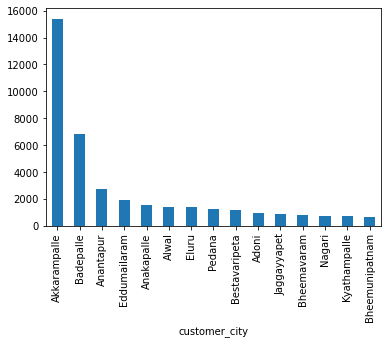

In [104]:
# customers with the most new customers
merged.groupby("customer_city")["first_order"].sum().sort_values(ascending=False).head(15).plot(kind="bar")

<AxesSubplot:xlabel='seller_state,customer_state'>

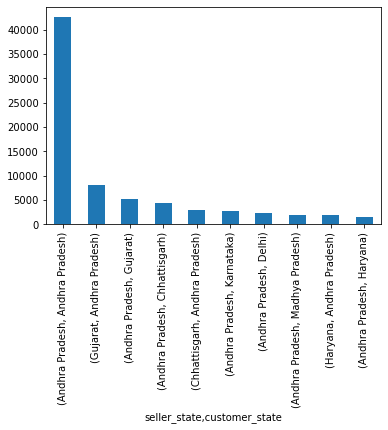

In [119]:
# which route of transport is used the most
df = merged.groupby(["seller_state","customer_state"])["order_id"].count().sort_values(ascending=False).head(10)
df.plot(kind="bar")

In [124]:
print(f"{df.index[0][0]} to {df.index[0][1]} is the most used route with {df[0]} total order shipped between them")
print(f"{df.index[1][0]} to {df.index[1][1]} is the 2nd most used route with {df[1]} total order shipped between them")

Andhra Pradesh to Andhra Pradesh is the most used route with 42567 total order shipped between them
Gujarat to Andhra Pradesh is the 2nd most used route with 8106 total order shipped between them
